In [1]:
import pandas as pd
from pathlib import Path
from scipy.io import loadmat
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from fastai import *
from fastai.vision import *

In [42]:
#!mv data/cars_train data/train
#!mv data/cars_test data/test

In [11]:
#!wget https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
#!tar -zxvf car_devkit.tgz -C data

--2019-06-05 09:04:47--  https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘car_devkit.tgz’

car_devkit.tgz      100%[===================>] 323.20K   207KB/s    in 1.6s    

2019-06-05 09:04:50 (207 KB/s) - ‘car_devkit.tgz’ saved [330960/330960]



In [319]:
#!wget http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat
#!mv cars_test_annos_withlabels.mat data/

--2019-06-05 15:42:06--  http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185758 (181K) [text/plain]
Saving to: ‘cars_test_annos_withlabels.mat.1’

cars_test_annos_wit 100%[===================>] 181.40K   134KB/s    in 1.4s    

2019-06-05 15:42:08 (134 KB/s) - ‘cars_test_annos_withlabels.mat.1’ saved [185758/185758]



Create a unified folder where test images and train images are in for fastai learner to test at the end of training

In [418]:
#!mkdir data/all_img
#!cp -a data/test/. data/all_img    
#cd data/all_img && rename 's/^/test_/' *  # renaming all the test images in the folder with 'test' suffix
#!cp -a data/train/. data/all_img   

In [3]:
train_path = 'data/train/'
cropped_path = 'data/cropped_train/'
test_path = 'data/test/'
all_img_path = 'data/all_img'
CROPPED_PATH = Path(cropped_path)

In [ ]:
#CROPPED_PATH.mkdir(parents=True, exist_ok=True)

Fixed code from [Devon from Kaggle](https://www.kaggle.com/criticalmassacre/inaccurate-labels-in-stanford-cars-data-set) 

In [4]:
train_an_pth = 'data/devkit/cars_train_annos.mat'
test_an_pth = 'data/cars_test_annos_withlabels.mat'
classes_pth = 'data/devkit/cars_meta.mat'

def get_labels(annos_path, classes_path):
    car_an = loadmat(annos_path)
    car_meta = loadmat(classes_path)
    annotations = car_an["annotations"][0,:]
    total_classes = len(car_meta["class_names"][0])
    class_names = dict(zip(range(1,total_classes+1),[c[0] for c in car_meta["class_names"][0]]))
    
    labelled_images = {}
    dataset = []
    for arr in annotations:
        # the last entry in the row is the image name
        # The rest is the data, first bbox, then classid
        dataset.append([y[0][0] for y in arr][0:5]+[arr[5][0]])
    # Convert to a DataFrame, and specify the column names
    temp_df = pd.DataFrame(dataset, 
                      columns =['BBOX_X1','BBOX_Y1','BBOX_X2','BBOX_Y2','ClassID','filename'])

    temp_df = temp_df.assign(ClassName=temp_df.ClassID.map(dict(class_names)))
    temp_df.columns = ['bbox_x1','bbox_y1','bbox_x2','bbox_y2','class_id','filename', 'class_name']
    return temp_df

In [5]:
train_df = get_labels(train_an_pth, classes_pth)
train_df['test'] = 0
train_df.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,filename,class_name,test
0,39,116,569,375,14,00001.jpg,Audi TTS Coupe 2012,0
1,36,116,868,587,3,00002.jpg,Acura TL Sedan 2012,0
2,85,109,601,381,91,00003.jpg,Dodge Dakota Club Cab 2007,0
3,621,393,1484,1096,134,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,0
4,14,36,133,99,106,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,0


In [6]:
test_df = get_labels(test_an_pth,classes_pth)
test_df['test'] = 1
test_df.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,filename,class_name,test
0,30,52,246,147,181,00001.jpg,Suzuki Aerio Sedan 2007,1
1,100,19,576,203,103,00002.jpg,Ferrari 458 Italia Convertible 2012,1
2,51,105,968,659,145,00003.jpg,Jeep Patriot SUV 2012,1
3,67,84,581,407,187,00004.jpg,Toyota Camry Sedan 2012,1
4,140,151,593,339,185,00005.jpg,Tesla Model S Sedan 2012,1


In [7]:
test_df_all_img = test_df.copy()
test_df_all_img['filename'] = test_df_all_img['filename'].map(lambda x: f'test_{x}')
test_df_all_img.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,filename,class_name,test
0,30,52,246,147,181,test_00001.jpg,Suzuki Aerio Sedan 2007,1
1,100,19,576,203,103,test_00002.jpg,Ferrari 458 Italia Convertible 2012,1
2,51,105,968,659,145,test_00003.jpg,Jeep Patriot SUV 2012,1
3,67,84,581,407,187,test_00004.jpg,Toyota Camry Sedan 2012,1
4,140,151,593,339,185,test_00005.jpg,Tesla Model S Sedan 2012,1


In [463]:
#all_img_df = pd.concat([train_df,test_df_all_img])
#all_img_df = all_img_df.loc[:,['filename', 'class_name', 'class_id', 'test']]
#all_img_df.to_csv('all_img.csv',index=False)

In [464]:
#Add cropped file names 
train_df['filename_cropped'] = train_df['filename'].map(lambda x: f'cropped_{x}')
#train_df.to_csv('train_labels.csv',index=False)

In [465]:
#Ensuring class names and class ids are mapped properly 
train_df['class_name'].nunique(), train_df['class_id'].nunique()

(196, 196)

In [275]:
def _crop(df, path, i):
    img = Image.open(path + df['filename'][i])
    x1 = df['bbox_x1'][i]
    y1 =df['bbox_y1'][i]
    y2 = df['bbox_y2'][i]
    x2 = df['bbox_x2'][i]
    bbox = (x1,y1,x2,y2)
    return img.crop(bbox)

def save(img,df,path,i): 
    return img.save(f'{path + df["filename_cropped"][i]}')
                    
def get_cropped_image(df,path,cropped_path,i):
    cropped = _crop(df,path,i)
    return save(cropped,df,cropped_path,i)
    

In [ ]:
#Generate cropped images
list(map(lambda x: get_cropped_image(train_df,train_path,cropped_path,x), list(range(len(train_df)))))

#### Commence training: Stage-1 (resnet152)
- Setting up data bunch and transformations

In [8]:
tfms = get_transforms()
trn_df_labels = train_df[['filename','class_name']]

src = (ImageList.from_df(trn_df_labels,train_path, cols='filename')
       .split_by_rand_pct(0.2, seed=42).label_from_df('class_name'))

In [9]:
data128 = (src.transform(tfms,size=128).databunch(bs=64).normalize(imagenet_stats))

In [10]:
learn = cnn_learner(data128,models.resnet152,metrics=[error_rate,accuracy, Precision(average='weighted'), Recall(average='weighted')])

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/jupyter/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 88162751.79it/s]


In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-02


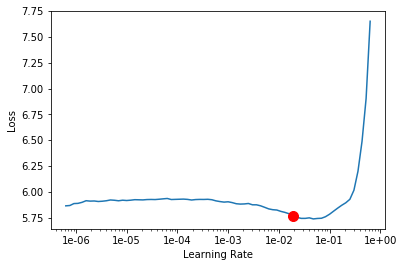

In [12]:
learn.recorder.plot(suggestion=True)

In [13]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,4.873180,4.859406,0.941032,0.058968,nan,0.058968,01:00
1,4.132984,3.936664,0.866708,0.133292,nan,0.133292,00:58
2,3.306090,3.048801,0.754300,0.245700,nan,0.245700,00:58
3,2.511158,2.081804,0.544226,0.455774,nan,0.455774,00:58
4,1.926842,1.813118,0.477887,0.522113,0.562765,0.522113,00:58


In [14]:
learn.save('resnet-152-128-v1-5ep-lr1e-2')

#### Stage-2
- Unfreezing the model to train body's weight

In [15]:
#Load the best model from stage-1
learn.load('resnet-152-128-v1-5ep-lr1e-2');

In [16]:
learn.unfreeze()

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


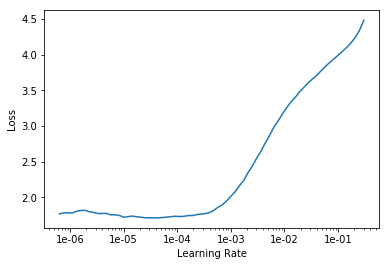

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,1.702032,1.763590,0.475430,0.524570,0.576790,0.524570,01:12
1,1.648375,1.666364,0.433047,0.566953,0.612326,0.566953,01:13
2,1.500812,1.569841,0.415848,0.584152,0.619872,0.584152,01:11
3,1.350143,1.505707,0.383907,0.616093,0.650090,0.616093,01:12
4,1.297982,1.500042,0.386364,0.613636,0.644276,0.613636,01:12


In [20]:
learn.save('resnet-152-128-v2-5ep-lr1e-6,3e-4')

#### Stage-3
- Resizing the images to 224

In [21]:
learn.load('resnet-152-128-v2-5ep-lr1e-6,3e-4');

In [22]:
data224= (src.transform(tfms,size=224).databunch(bs=64).normalize(imagenet_stats))

In [247]:
learn.data = data224

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


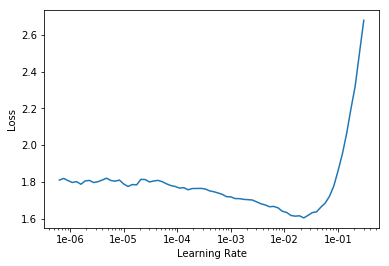

In [238]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [248]:
learn.fit_one_cycle(5,3e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,1.351839,1.182503,0.328624,0.671376,0.704447,0.671376,01:13
1,1.133406,1.146795,0.329238,0.670762,0.714662,0.670762,01:13
2,0.932171,0.997145,0.287469,0.712531,0.743484,0.712531,01:13
3,0.733333,0.908603,0.261671,0.738329,0.757512,0.738329,01:13
4,0.614609,0.900460,0.264742,0.735258,0.757165,0.735258,01:15


In [244]:
learn.save('resnet50-v2-224-5ep-lr1e-2')

In [249]:
learn.save('resnet50-v2-224-5ep-lr3e-3')

#### Stage-4
- Unfreezing the model for data sized 224

In [257]:
learn.load('resnet50-v2-224-5ep-lr1e-2');

In [258]:
learn.unfreeze()

In [259]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


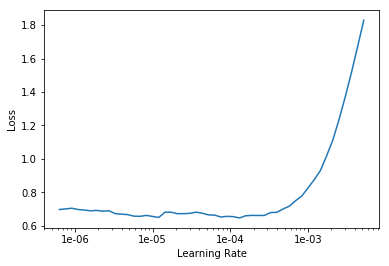

In [260]:
learn.recorder.plot()

In [261]:
learn.fit_one_cycle(5,slice(3e-6,3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.645909,0.911374,0.259214,0.740786,0.764781,0.740786,01:31
1,0.646370,0.886123,0.247543,0.752457,0.773807,0.752457,01:32
2,0.576843,0.850081,0.235258,0.764742,0.780163,0.764742,01:33
3,0.500295,0.806696,0.219902,0.780098,0.795138,0.780098,01:32
4,0.449587,0.805641,0.218059,0.781941,0.795029,0.781941,01:32


In [256]:
learn.save('resnet50-v3-224-5ep-lr1e-5')

In [291]:
learn.save('resnet50-v3-224-5ep-lr3e-6,3e-4')

#### Stage-5
- Last resizing to 299 

In [336]:
learn.load('resnet50-v3-224-5ep-lr3e-6,3e-4');

In [337]:
data299 = (src.transform(tfms,size=299).databunch(bs=64//2).normalize(imagenet_stats))

In [484]:
learn.data = data299

In [339]:
learn.freeze()

In [340]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


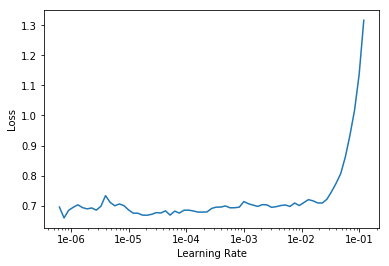

In [341]:
learn.recorder.plot()

In [299]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.669053,0.837330,0.233415,0.766585,0.784629,0.766585,02:10
1,0.650914,0.809797,0.222973,0.777027,0.801958,0.777027,02:08
2,0.555341,0.776597,0.217445,0.782555,0.805800,0.782555,02:08
3,0.455643,0.738147,0.194103,0.805897,0.823040,0.805897,02:08
4,0.404386,0.732418,0.195332,0.804668,0.821466,0.804668,02:09


In [328]:
learn.save('resnet50-v1-299-5ep-lr3e-3')

#### Stage-6 
- Unfreezing and last 5 epochs 

In [485]:
learn.load('resnet50-v1-299-5ep-lr3e-3');

In [486]:
learn.unfreeze()

In [488]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


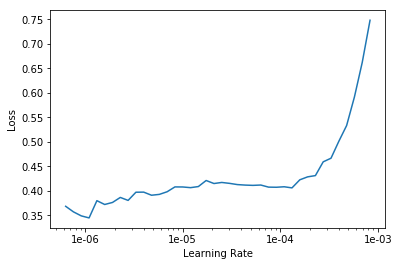

In [487]:
learn.recorder.plot()

In [489]:
learn.fit_one_cycle(5,slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.382608,0.726346,0.191646,0.808354,0.824645,0.808354,02:46
1,0.374835,0.710805,0.194717,0.805283,0.822556,0.805283,02:46
2,0.359276,0.707630,0.192260,0.807740,0.824675,0.807740,02:47
3,0.377893,0.701999,0.192875,0.807125,0.822989,0.807125,02:47
4,0.344796,0.704292,0.195332,0.804668,0.821273,0.804668,02:47


In [490]:
learn.save('resnet50-v2-299-5ep-lr1e-6,1e-5')

#### Conclusion 
- This model started to overfit and training should stop as it doesn't show any increase in accuracy

### Test Set Performance

In [478]:
data_test = (ImageList.from_df(all_img_df,all_img_path,cols='filename')
           .split_from_df(col='test').label_from_df(cols='class_name').transform(tfms,size=299).databunch(bs=64).normalize(imagenet_stats))

In [491]:
learn.load('resnet50-v2-299-5ep-lr1e-6,1e-5');

In [492]:
learn.data = data_test

In [493]:
test_preds, test_ys = learn.TTA()

In [494]:
accuracy(test_preds,test_ys)

tensor(0.8261)

Baseline accuracy will be 82.61% with resnet50